# VGG-17: CIFAR-10 & PyTorch

In [ ]:
# Specify GPU to be used-
# %env CUDA_DEVICE_ORDER = PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES = 0

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pickle

/home/arjun/anaconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f"torch version: {torch.__version__}")

torch version: 1.11.0


In [3]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 2
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080


In [4]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [5]:
# Specify hyper-parameters
batch_size = 64
num_classes = 10
num_epochs = 85
learning_rate = 0.01

### CIFAR-10 data pre-processing

In [6]:
# Define transformations for training and test sets-
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding = 4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465),
            (0.2023, 0.1994, 0.2010)
        ),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465),
            (0.2023, 0.1994, 0.2010)
        ),
    ]
)

In [7]:
# Load CIFAR-10 dataset-
train_dataset = torchvision.datasets.CIFAR10(
    root = './data', train = True,
    download = True, transform = transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root = './data', train = False,
    download = True, transform = transform_test
)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = batch_size,
    shuffle = True
    )

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset, batch_size = batch_size,
    shuffle = True
    )

In [9]:
print(f"len(train_dataset) = {len(train_dataset)} & len(test_dataset) = {len(test_dataset)}")

len(train_dataset) = 50000 & len(test_dataset) = 10000


In [10]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 782 & len(test_loader) = 157


In [11]:
len(train_dataset) / batch_size, len(test_dataset) / batch_size

(781.25, 156.25)

In [12]:
print(f"len(train_dataset) = {len(train_dataset)} & len(test_dataset) = {len(test_dataset)}")

len(train_dataset) = 50000 & len(test_dataset) = 10000


In [13]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 782 & len(test_loader) = 157


In [14]:
len(train_dataset) / batch_size, len(test_dataset) / batch_size

(781.25, 156.25)

In [15]:
# Sanity check-
images, labels = next(iter(train_loader))

images.size(), labels.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [16]:
# Unnormalize images-
images = images / 2 + 0.5
images = np.transpose(images.numpy(), (0, 2, 3, 1))

images.shape

(64, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

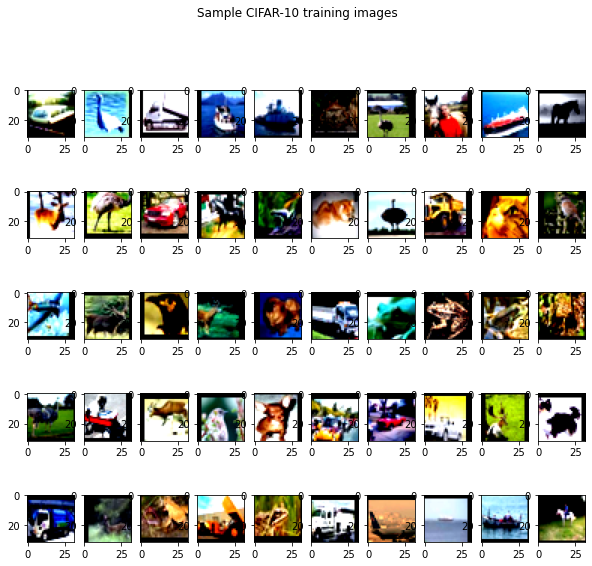

In [17]:
# Visualize 50 images from training set-
plt.figure(figsize = (10, 9))

for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(images[i])
    
plt.suptitle("Sample CIFAR-10 training images")
plt.show()

In [18]:
images.max(), images.min()

(1.8768656, -0.71453285)

In [18]:
del images, labels

### Define _VGG-17_ CNN architecture

In [19]:
class VGGBlock(nn.Module):
    '''
    VGG block within a VGG-* CNN model
    '''
    def __init__(self, input_channels, num_channels, padding_size = 1,
                 stride_size = 1, use_extra_conv = False, dropout = 0.2):
        super().__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels = input_channels, out_channels = num_channels,
            kernel_size = 3, padding = padding_size,
            stride = stride_size, bias = False
        )
        
        self.dropout = nn.Dropout(p = dropout)
        
        self.conv2 = nn.Conv2d(
            in_channels = num_channels, out_channels = num_channels,
            kernel_size = 3, padding = padding_size,
            stride = stride_size, bias = False
        )
        
        if use_extra_conv:
            self.conv3 = nn.Conv2d(
                in_channels = num_channels, out_channels = num_channels,
                kernel_size = 3, padding = padding_size,
                stride = stride_size, bias = False
            )
            
            self.conv4 = nn.Conv2d(
                in_channels = num_channels, out_channels = num_channels,
                kernel_size = 3, padding = padding_size,
                stride = stride_size, bias = False
            )
        else:
            self.conv3 = False
            self.conv4 = False
        
        self.pool = nn.MaxPool2d(
            kernel_size = 2, stride = 2)
            # padding = 1)
        
        self.bn1 = nn.BatchNorm2d(num_features = num_channels)
        self.bn2 = nn.BatchNorm2d(num_features = num_channels)

        if use_extra_conv:
            self.bn3 = nn.BatchNorm2d(num_features = num_channels)
            self.bn4 = nn.BatchNorm2d(num_features = num_channels)
        
        self.initialize_weights()
    
    
    def forward(self, X):
        Y = self.dropout(F.relu(self.bn1(self.conv1(X))))
        Y = self.dropout(F.relu(self.bn2(self.conv2(Y))))
        
        if self.conv3 and self.conv4:
            Y = self.dropout(F.relu(self.bn3(self.conv3(Y))))
            Y = self.dropout(F.relu(self.bn4(self.conv4(Y))))
            Y = self.pool(Y)
        else:
            Y = self.pool(Y)
        
        return Y
    
    
    def shape_computation(self, X):
        Y = self.bn1(self.conv1(X))
        print(f"self.bn(conv1(X)).shape: {Y.shape}")
        
        Y = self.bn2(self.conv2(Y))
        print(f"self.bn(conv2(Y)).shape: {Y.shape}")
        
        if self.conv3 and self.conv4:
            Y = self.bn3(self.conv3(Y))
            print(f"self.bn(conv3(Y)).shape: {Y.shape}")
            
            Y = self.bn4(self.conv4(Y))
            print(f"self.bn(conv4(Y)).shape: {Y.shape}")
            
            Y = self.pool(Y)
            print(f"self.pool(Y).shape: {Y.shape}")
        else:
            Y = self.pool(Y)
            print(f"self.pool(Y).shape: {Y.shape}")
        

    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)

                '''
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                '''
            
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
                

In [21]:
class VGG17(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = VGGBlock(input_channels = 3, num_channels = 64, dropout = 0)
        self.block2 = VGGBlock(input_channels = 64, num_channels = 128)
        self.block3 = VGGBlock(
            input_channels = 128, num_channels = 256,
            use_extra_conv = True, dropout = 0.3)
        self.block4 = VGGBlock(
            input_channels = 256, num_channels = 512,
            use_extra_conv = True, dropout = 0.3)
        self.block5 = VGGBlock(
            input_channels = 512, num_channels = 512,
            use_extra_conv = True, dropout = 0.3)
        # self.pool = nn.AdaptiveAvgPool1d()
        self.flatten = nn.Flatten()
        self.output_layer = nn.Linear(in_features = 512, out_features = 10)
        
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        # x = self.pool(x)
        x = self.flatten(x)
        x = self.output_layer(x)
        return x
    

### Multi-GPU Training in PyTorch

- [Multi-GPU Examples](https://pytorch.org/tutorials/beginner/former_torchies/parallelism_tutorial.html)

- [Data Parallelism](https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html)

In [22]:
# Initialize VGG-17 architecture-
model = VGG17()

In [ ]:
# Use all available GPUs-
model = nn.DataParallel(model)
model.to(device)

In [24]:
# Sanity check-
x, y = next(iter(train_loader))
x = x.to(device)
y = y.to(device)

In [25]:
x.shape, y.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [26]:
out = model(x)

In [27]:
out.shape

torch.Size([64, 10])

In [28]:
del x, y, out

In [29]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([64, 3, 3, 3]) has 1728 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([128, 64, 3, 3]) has 73728 parameters
layer.shape = torch.Size([128, 128, 3, 3]) has 147456 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([256, 128, 3, 3]) has 294912 parameters
layer.shape = torch.Size([256, 256, 3, 3]) has 589824 parameters
layer.shape = torch.Size([256, 256, 3, 3]) has 589824 parameters
layer.shape = torch.Size([256, 256, 3, 3]) has 589824 parameters
layer.shape = torch.Size([256]) has 256 parameters
layer.shape = torch.Size([256]) has 256

In [30]:
print(f"Total number of parameters in VGG-17 CNN = {tot_params}")

Total number of parameters in VGG-17 CNN = 20035018


In [ ]:
'''
# Print layer names-
for layer in model.state_dict().keys():
    print(f"{layer} has dimension = {model.state_dict()[layer].shape}")
'''

In [ ]:
# Save random initial weights-
torch.save(model.state_dict(), 'VGG18_random_weights.pth')

In [ ]:
# Load randomly initialised weights-
'''
test_model = VGG17
test_model = nn.DataParallel(test_model)
test_model.to(device)
test_model.load_state_dict(torch.load("VGG17_random_weights.pth"))
'''

### Train _VGG-17_ CNN with Learning Rate Scheduler

Training dataset size = 50K, batch-size = 64, number of training steps per epoch = 50K / 64 = 781.25

After an initial LR warmup of 13 epochs or, 10156.25 = 10157 training iterations:

- For the next 32 epochs, or, 25000 steps - until 45rd epoch, use lr = 0.1.

- For the next 25 epochs, or, 19531.25 steps - until 70th epoch, use lr = 0.01.

- For remaining epochs, use lr = 0.001.

In [31]:
boundaries = [35157, 53125]
values = [0.1, 0.01, 0.001]

In [32]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0, momentum = 0.9, weight_decay = 5e-4)

In [33]:
# Sanity check-
optimizer.param_groups[0]['lr']

0.0

In [34]:
def decay_function(step, boundaries = [35157, 53125], values = [0.1, 0.01, 0.001]):
    
    for idx, bound in enumerate(boundaries):
        if step < bound:
            return values[idx]

    return values[-1]


In [35]:
class schedule():

    def __init__(self, initial_learning_rate = 0.1, warmup_steps = 1000, decay_func = None):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_func = decay_func
        self.warmup_step_size = initial_learning_rate/warmup_steps
        self.current_lr = 0

    def get_lr(self, step):
        if step == 0:
            return self.current_lr
        elif step <= self.warmup_steps:
            self.current_lr+=self.warmup_step_size
            return self.current_lr
        elif step > self.warmup_steps:
            if self.decay_func:
                return self.decay_func(step)
        else:
            return self.current_lr
        

In [36]:
# Initial linear LR warmup: 781.25 x 13 = 10156.25 steps in 13 epochs.
custom_lr_scheduler = schedule(
    initial_learning_rate = 0.1, warmup_steps = 10157,
    decay_func = decay_function
)

In [37]:
step = 0

In [38]:
def train_model_progress(model, train_loader):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            global step
            optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)

            step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()


In [39]:
def test_model_progress(model, test_loader):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [40]:
# Python3 dict to contain training metrics-
training_history_lr_scheduler = {}

In [41]:
# Initialize parameters saving 'best' models-
best_val_acc = 0
loc_patience = 0

In [42]:
for epoch in range(num_epochs):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(model, train_loader)
    val_loss, val_acc = test_model_progress(model, test_loader)
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history_lr_scheduler[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    
    # Save best weights achieved until now-
    if (val_acc > best_val_acc):
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_acc = val_acc

        print(f"Saving model with highest val_acc = {val_acc:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "VGG17_best_model.pth")
        

Validation: : 100%|██████████| 157/157 [00:04<00:00, 38.14batch/s, val_acc=10, val_loss=3.35]  



epoch: 1 training loss = 2.1263, training accuracy = 18.98%, val_loss = 3.3541, val_accuracy = 10.00% & LR = 0.0077

Saving model with highest val_acc = 10.0000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 38.03batch/s, val_acc=19.1, val_loss=2.27]



epoch: 2 training loss = 1.7362, training accuracy = 31.90%, val_loss = 2.2743, val_accuracy = 19.05% & LR = 0.0154

Saving model with highest val_acc = 19.0500



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.97batch/s, val_acc=43, val_loss=1.61]  



epoch: 3 training loss = 1.4818, training accuracy = 44.27%, val_loss = 1.6050, val_accuracy = 42.97% & LR = 0.0231

Saving model with highest val_acc = 42.9700



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.91batch/s, val_acc=62.7, val_loss=1.22] 



epoch: 4 training loss = 1.1923, training accuracy = 57.94%, val_loss = 1.2184, val_accuracy = 62.70% & LR = 0.0308

Saving model with highest val_acc = 62.7000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.87batch/s, val_acc=58.3, val_loss=1.19] 



epoch: 5 training loss = 1.0607, training accuracy = 63.75%, val_loss = 1.1878, val_accuracy = 58.32% & LR = 0.0385



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.93batch/s, val_acc=58.1, val_loss=1.28] 



epoch: 6 training loss = 0.9631, training accuracy = 67.54%, val_loss = 1.2829, val_accuracy = 58.13% & LR = 0.0462



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.57batch/s, val_acc=66.6, val_loss=1.08] 



epoch: 7 training loss = 0.9012, training accuracy = 70.20%, val_loss = 1.0843, val_accuracy = 66.60% & LR = 0.0539

Saving model with highest val_acc = 66.6000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.45batch/s, val_acc=65.7, val_loss=1.09] 



epoch: 8 training loss = 0.8700, training accuracy = 71.66%, val_loss = 1.0910, val_accuracy = 65.73% & LR = 0.0616



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.87batch/s, val_acc=75.4, val_loss=0.848]



epoch: 9 training loss = 0.8541, training accuracy = 72.21%, val_loss = 0.8479, val_accuracy = 75.41% & LR = 0.0693

Saving model with highest val_acc = 75.4100



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.83batch/s, val_acc=64.1, val_loss=1.08] 



epoch: 10 training loss = 0.8493, training accuracy = 72.52%, val_loss = 1.0760, val_accuracy = 64.08% & LR = 0.0770



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.65batch/s, val_acc=66, val_loss=1.08]   



epoch: 11 training loss = 0.8480, training accuracy = 72.81%, val_loss = 1.0807, val_accuracy = 66.02% & LR = 0.0847



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.64batch/s, val_acc=68.6, val_loss=1.07] 



epoch: 12 training loss = 0.8612, training accuracy = 72.34%, val_loss = 1.0680, val_accuracy = 68.63% & LR = 0.0924



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.57batch/s, val_acc=70.2, val_loss=0.972]



epoch: 13 training loss = 0.8710, training accuracy = 71.96%, val_loss = 0.9723, val_accuracy = 70.16% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 36.82batch/s, val_acc=69.3, val_loss=1.01] 



epoch: 14 training loss = 0.8761, training accuracy = 72.39%, val_loss = 1.0139, val_accuracy = 69.26% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.08batch/s, val_acc=72.6, val_loss=0.867]



epoch: 15 training loss = 0.8539, training accuracy = 72.92%, val_loss = 0.8668, val_accuracy = 72.61% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.68batch/s, val_acc=62.4, val_loss=1.16] 



epoch: 16 training loss = 0.8495, training accuracy = 72.85%, val_loss = 1.1591, val_accuracy = 62.39% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.74batch/s, val_acc=66.4, val_loss=1.06] 



epoch: 17 training loss = 0.8397, training accuracy = 73.25%, val_loss = 1.0595, val_accuracy = 66.40% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.62batch/s, val_acc=74, val_loss=0.904]  



epoch: 18 training loss = 0.8385, training accuracy = 73.42%, val_loss = 0.9035, val_accuracy = 74.02% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.57batch/s, val_acc=64, val_loss=1.11]   



epoch: 19 training loss = 0.8261, training accuracy = 73.79%, val_loss = 1.1074, val_accuracy = 64.02% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.43batch/s, val_acc=64.2, val_loss=1.18] 



epoch: 20 training loss = 0.8211, training accuracy = 73.94%, val_loss = 1.1836, val_accuracy = 64.23% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.34batch/s, val_acc=71.8, val_loss=0.97] 



epoch: 21 training loss = 0.8260, training accuracy = 73.71%, val_loss = 0.9698, val_accuracy = 71.83% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.77batch/s, val_acc=68.8, val_loss=0.982]



epoch: 22 training loss = 0.8098, training accuracy = 74.22%, val_loss = 0.9820, val_accuracy = 68.75% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.14batch/s, val_acc=72.4, val_loss=0.935]



epoch: 23 training loss = 0.8172, training accuracy = 73.85%, val_loss = 0.9348, val_accuracy = 72.38% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.64batch/s, val_acc=72.5, val_loss=0.884]



epoch: 24 training loss = 0.8138, training accuracy = 74.15%, val_loss = 0.8842, val_accuracy = 72.49% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.63batch/s, val_acc=70.7, val_loss=0.961]



epoch: 25 training loss = 0.8180, training accuracy = 74.07%, val_loss = 0.9612, val_accuracy = 70.74% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.68batch/s, val_acc=68.4, val_loss=0.994]



epoch: 26 training loss = 0.8136, training accuracy = 74.08%, val_loss = 0.9935, val_accuracy = 68.40% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.67batch/s, val_acc=71.8, val_loss=0.959]



epoch: 27 training loss = 0.8126, training accuracy = 74.02%, val_loss = 0.9595, val_accuracy = 71.81% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.73batch/s, val_acc=70.5, val_loss=1]    



epoch: 28 training loss = 0.8000, training accuracy = 74.54%, val_loss = 1.0008, val_accuracy = 70.48% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.79batch/s, val_acc=68.4, val_loss=1.03] 



epoch: 29 training loss = 0.8047, training accuracy = 74.32%, val_loss = 1.0284, val_accuracy = 68.36% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 38.00batch/s, val_acc=72.1, val_loss=0.91] 



epoch: 30 training loss = 0.8063, training accuracy = 74.36%, val_loss = 0.9098, val_accuracy = 72.14% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.46batch/s, val_acc=63, val_loss=1.19]   



epoch: 31 training loss = 0.7893, training accuracy = 75.03%, val_loss = 1.1927, val_accuracy = 62.98% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 38.08batch/s, val_acc=68.3, val_loss=1.04] 



epoch: 32 training loss = 0.7892, training accuracy = 75.06%, val_loss = 1.0445, val_accuracy = 68.34% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 38.25batch/s, val_acc=75.8, val_loss=0.87] 



epoch: 33 training loss = 0.7956, training accuracy = 74.85%, val_loss = 0.8705, val_accuracy = 75.75% & LR = 0.1000

Saving model with highest val_acc = 75.7500



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.45batch/s, val_acc=68.8, val_loss=1.03] 



epoch: 34 training loss = 0.7902, training accuracy = 74.98%, val_loss = 1.0285, val_accuracy = 68.81% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.37batch/s, val_acc=65.5, val_loss=1.11] 



epoch: 35 training loss = 0.7915, training accuracy = 75.09%, val_loss = 1.1124, val_accuracy = 65.46% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.35batch/s, val_acc=63, val_loss=1.21]   



epoch: 36 training loss = 0.7866, training accuracy = 75.11%, val_loss = 1.2079, val_accuracy = 62.99% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.35batch/s, val_acc=68.6, val_loss=1.04] 



epoch: 37 training loss = 0.7958, training accuracy = 74.66%, val_loss = 1.0410, val_accuracy = 68.57% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.37batch/s, val_acc=69.8, val_loss=0.999]



epoch: 38 training loss = 0.7909, training accuracy = 74.73%, val_loss = 0.9989, val_accuracy = 69.78% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 36.85batch/s, val_acc=66.5, val_loss=1.16] 



epoch: 39 training loss = 0.7872, training accuracy = 75.03%, val_loss = 1.1603, val_accuracy = 66.52% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.33batch/s, val_acc=57.2, val_loss=1.29] 



epoch: 40 training loss = 0.7829, training accuracy = 74.99%, val_loss = 1.2889, val_accuracy = 57.24% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.72batch/s, val_acc=67.5, val_loss=1.05] 



epoch: 41 training loss = 0.7868, training accuracy = 75.09%, val_loss = 1.0518, val_accuracy = 67.55% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.78batch/s, val_acc=59.8, val_loss=1.23] 



epoch: 42 training loss = 0.7842, training accuracy = 75.17%, val_loss = 1.2343, val_accuracy = 59.75% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.77batch/s, val_acc=73.1, val_loss=0.938]



epoch: 43 training loss = 0.7874, training accuracy = 74.98%, val_loss = 0.9378, val_accuracy = 73.13% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.79batch/s, val_acc=73, val_loss=0.939]  



epoch: 44 training loss = 0.7797, training accuracy = 75.33%, val_loss = 0.9391, val_accuracy = 73.02% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.64batch/s, val_acc=81.9, val_loss=0.693]



epoch: 45 training loss = 0.7895, training accuracy = 74.81%, val_loss = 0.6931, val_accuracy = 81.91% & LR = 0.0100

Saving model with highest val_acc = 81.9100



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.67batch/s, val_acc=87, val_loss=0.479]  



epoch: 46 training loss = 0.4961, training accuracy = 84.03%, val_loss = 0.4789, val_accuracy = 86.98% & LR = 0.0100

Saving model with highest val_acc = 86.9800



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.08batch/s, val_acc=87.5, val_loss=0.469]



epoch: 47 training loss = 0.4339, training accuracy = 85.83%, val_loss = 0.4689, val_accuracy = 87.49% & LR = 0.0100

Saving model with highest val_acc = 87.4900



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.68batch/s, val_acc=88.5, val_loss=0.429]



epoch: 48 training loss = 0.4082, training accuracy = 86.57%, val_loss = 0.4292, val_accuracy = 88.48% & LR = 0.0100

Saving model with highest val_acc = 88.4800



Validation: : 100%|██████████| 157/157 [00:04<00:00, 38.00batch/s, val_acc=88.1, val_loss=0.429]



epoch: 49 training loss = 0.3842, training accuracy = 87.31%, val_loss = 0.4293, val_accuracy = 88.11% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.90batch/s, val_acc=88, val_loss=0.418]  



epoch: 50 training loss = 0.3638, training accuracy = 88.05%, val_loss = 0.4183, val_accuracy = 87.97% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.68batch/s, val_acc=88.3, val_loss=0.41] 



epoch: 51 training loss = 0.3567, training accuracy = 88.24%, val_loss = 0.4103, val_accuracy = 88.34% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.65batch/s, val_acc=87.6, val_loss=0.442]



epoch: 52 training loss = 0.3429, training accuracy = 88.90%, val_loss = 0.4419, val_accuracy = 87.59% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.99batch/s, val_acc=89.2, val_loss=0.384]



epoch: 53 training loss = 0.3352, training accuracy = 89.09%, val_loss = 0.3843, val_accuracy = 89.18% & LR = 0.0100

Saving model with highest val_acc = 89.1800



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.97batch/s, val_acc=88.5, val_loss=0.418]



epoch: 54 training loss = 0.3324, training accuracy = 89.10%, val_loss = 0.4179, val_accuracy = 88.49% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.32batch/s, val_acc=89, val_loss=0.396]  



epoch: 55 training loss = 0.3203, training accuracy = 89.52%, val_loss = 0.3958, val_accuracy = 89.02% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.92batch/s, val_acc=87.4, val_loss=0.407]



epoch: 56 training loss = 0.3188, training accuracy = 89.53%, val_loss = 0.4075, val_accuracy = 87.41% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.95batch/s, val_acc=88.4, val_loss=0.399]



epoch: 57 training loss = 0.3152, training accuracy = 89.68%, val_loss = 0.3986, val_accuracy = 88.41% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.87batch/s, val_acc=87.3, val_loss=0.428]



epoch: 58 training loss = 0.3190, training accuracy = 89.60%, val_loss = 0.4285, val_accuracy = 87.26% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.59batch/s, val_acc=89.3, val_loss=0.376]



epoch: 59 training loss = 0.3095, training accuracy = 89.85%, val_loss = 0.3755, val_accuracy = 89.34% & LR = 0.0100

Saving model with highest val_acc = 89.3400



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.69batch/s, val_acc=89.1, val_loss=0.409]



epoch: 60 training loss = 0.3153, training accuracy = 89.74%, val_loss = 0.4086, val_accuracy = 89.13% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.59batch/s, val_acc=88.7, val_loss=0.404]



epoch: 61 training loss = 0.3160, training accuracy = 89.70%, val_loss = 0.4038, val_accuracy = 88.71% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.72batch/s, val_acc=88.9, val_loss=0.376]



epoch: 62 training loss = 0.3097, training accuracy = 89.79%, val_loss = 0.3756, val_accuracy = 88.91% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.13batch/s, val_acc=89, val_loss=0.39]   



epoch: 63 training loss = 0.3118, training accuracy = 89.90%, val_loss = 0.3904, val_accuracy = 89.03% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.70batch/s, val_acc=88.9, val_loss=0.405]



epoch: 64 training loss = 0.3163, training accuracy = 89.67%, val_loss = 0.4047, val_accuracy = 88.95% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.64batch/s, val_acc=87, val_loss=0.434]  



epoch: 65 training loss = 0.3102, training accuracy = 89.93%, val_loss = 0.4335, val_accuracy = 87.02% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.76batch/s, val_acc=87.1, val_loss=0.412]



epoch: 66 training loss = 0.3091, training accuracy = 89.92%, val_loss = 0.4124, val_accuracy = 87.10% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.90batch/s, val_acc=87.7, val_loss=0.405]



epoch: 67 training loss = 0.3131, training accuracy = 89.80%, val_loss = 0.4051, val_accuracy = 87.67% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:04<00:00, 38.08batch/s, val_acc=90.6, val_loss=0.358]



epoch: 68 training loss = 0.3066, training accuracy = 89.97%, val_loss = 0.3577, val_accuracy = 90.59% & LR = 0.0010

Saving model with highest val_acc = 90.5900



Validation: : 100%|██████████| 157/157 [00:04<00:00, 38.07batch/s, val_acc=91.5, val_loss=0.299]



epoch: 69 training loss = 0.2238, training accuracy = 92.72%, val_loss = 0.2986, val_accuracy = 91.47% & LR = 0.0010

Saving model with highest val_acc = 91.4700



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.59batch/s, val_acc=91.7, val_loss=0.28] 



epoch: 70 training loss = 0.1973, training accuracy = 93.45%, val_loss = 0.2796, val_accuracy = 91.72% & LR = 0.0010

Saving model with highest val_acc = 91.7200



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.13batch/s, val_acc=91.7, val_loss=0.271]



epoch: 71 training loss = 0.1831, training accuracy = 93.93%, val_loss = 0.2705, val_accuracy = 91.72% & LR = 0.0010



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.57batch/s, val_acc=91.8, val_loss=0.263]



epoch: 72 training loss = 0.1748, training accuracy = 94.26%, val_loss = 0.2631, val_accuracy = 91.81% & LR = 0.0010

Saving model with highest val_acc = 91.8100



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.63batch/s, val_acc=91.9, val_loss=0.259]



epoch: 73 training loss = 0.1696, training accuracy = 94.43%, val_loss = 0.2585, val_accuracy = 91.87% & LR = 0.0010

Saving model with highest val_acc = 91.8700



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.85batch/s, val_acc=92, val_loss=0.26]   



epoch: 74 training loss = 0.1640, training accuracy = 94.61%, val_loss = 0.2604, val_accuracy = 92.02% & LR = 0.0010

Saving model with highest val_acc = 92.0200



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.85batch/s, val_acc=92, val_loss=0.251]  



epoch: 75 training loss = 0.1598, training accuracy = 94.72%, val_loss = 0.2509, val_accuracy = 92.02% & LR = 0.0010



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.89batch/s, val_acc=92.1, val_loss=0.251]



epoch: 76 training loss = 0.1547, training accuracy = 94.84%, val_loss = 0.2506, val_accuracy = 92.11% & LR = 0.0010

Saving model with highest val_acc = 92.1100



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.80batch/s, val_acc=92.2, val_loss=0.246]



epoch: 77 training loss = 0.1511, training accuracy = 95.02%, val_loss = 0.2460, val_accuracy = 92.20% & LR = 0.0010

Saving model with highest val_acc = 92.2000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.80batch/s, val_acc=92.2, val_loss=0.25] 



epoch: 78 training loss = 0.1469, training accuracy = 95.05%, val_loss = 0.2502, val_accuracy = 92.21% & LR = 0.0010

Saving model with highest val_acc = 92.2100



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.20batch/s, val_acc=92.4, val_loss=0.244]



epoch: 79 training loss = 0.1456, training accuracy = 95.18%, val_loss = 0.2439, val_accuracy = 92.41% & LR = 0.0010

Saving model with highest val_acc = 92.4100



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.94batch/s, val_acc=92.3, val_loss=0.241]



epoch: 80 training loss = 0.1409, training accuracy = 95.38%, val_loss = 0.2411, val_accuracy = 92.29% & LR = 0.0010



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.36batch/s, val_acc=92.3, val_loss=0.243]



epoch: 81 training loss = 0.1390, training accuracy = 95.38%, val_loss = 0.2433, val_accuracy = 92.34% & LR = 0.0010



Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.51batch/s, val_acc=92.5, val_loss=0.239]



epoch: 82 training loss = 0.1385, training accuracy = 95.45%, val_loss = 0.2392, val_accuracy = 92.50% & LR = 0.0010

Saving model with highest val_acc = 92.5000



Validation: : 100%|██████████| 157/157 [00:04<00:00, 38.61batch/s, val_acc=92.2, val_loss=0.242]



epoch: 83 training loss = 0.1356, training accuracy = 95.50%, val_loss = 0.2415, val_accuracy = 92.24% & LR = 0.0010



Validation: : 100%|██████████| 157/157 [00:04<00:00, 38.56batch/s, val_acc=92.2, val_loss=0.24] 



epoch: 84 training loss = 0.1296, training accuracy = 95.81%, val_loss = 0.2404, val_accuracy = 92.19% & LR = 0.0010



Validation: : 100%|██████████| 157/157 [00:04<00:00, 38.34batch/s, val_acc=92.3, val_loss=0.238]


epoch: 85 training loss = 0.1288, training accuracy = 95.66%, val_loss = 0.2377, val_accuracy = 92.30% & LR = 0.0010



In [43]:
print(f"Finished training VGG-17 CNN on CIFAR-10 dataset")

Finished training VGG-17 CNN on CIFAR-10 dataset


In [44]:
# Save model from last training epoch-
torch.save(model.state_dict(), "VGG17_last_epoch_model.pth")

In [45]:
# Save training metrics as Python3 history for later analysis-
with open("VGG17_training_history_lr_scheduler.pkl", "wb") as file:
    pickle.dump(training_history_lr_scheduler, file)

In [46]:
# Initialize and load 'best' trained parameters from above-
best_model = VGG17()

# Utilize all available GPUs-
best_model = nn.DataParallel(best_model)
best_model.to(device)
best_model.load_state_dict(torch.load("VGG17_best_model.pth"))

<All keys matched successfully>

In [47]:
# Get validation loss and accuracy-
val_loss, val_acc = test_model_progress(best_model, test_loader)

Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.55batch/s, val_acc=92.5, val_loss=0.239]


In [48]:
val_loss_last, val_acc_last = test_model_progress(model = model, test_loader = test_loader)

Validation: : 100%|██████████| 157/157 [00:04<00:00, 37.97batch/s, val_acc=92.3, val_loss=0.238]


In [49]:
print(f"VGG-17 'best' model metrics: val_loss = {val_loss:.4f} & val_acc = {val_acc:.2f}%",
      f"\nlast epoch metrics: val_loss = {val_loss_last:.4f} & val_acc = {val_acc_last:.2f}%"
     )

VGG-17 'best' model metrics: val_loss = 0.2392 & val_acc = 92.50% 
last epoch metrics: val_loss = 0.2377 & val_acc = 92.30%


In [50]:
del model, best_model

### VGG-17 training visualizations

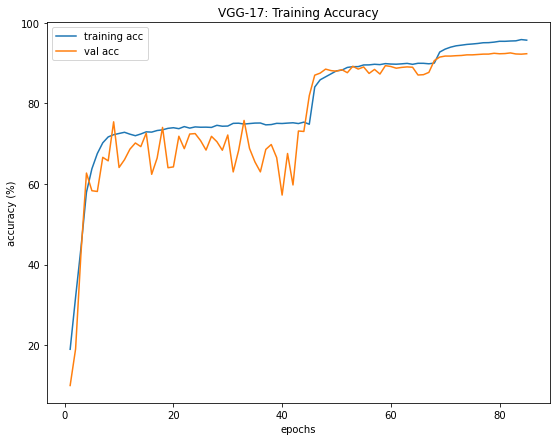

In [51]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['acc'] for k in training_history_lr_scheduler.keys()], label = 'training acc')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_acc'] for k in training_history_lr_scheduler.keys()], label = 'val acc')
plt.title("VGG-17: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

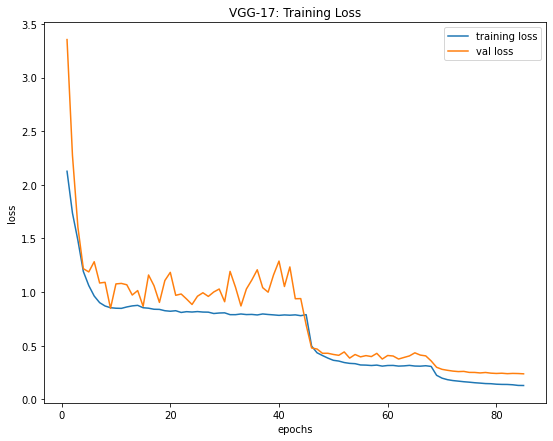

In [52]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['loss'] for k in training_history_lr_scheduler.keys()], label = 'training loss')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_loss'] for k in training_history_lr_scheduler.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VGG-17: Training Loss")
plt.show()

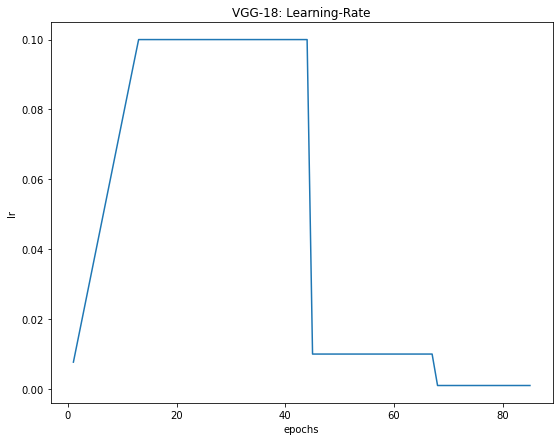

In [53]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['lr'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("VGG-18: Learning-Rate")
plt.show()